**Disclaimer**:
- This notebook is created for learning purpose only
- Dataset taken from personal collection

**Todo**:
- Try further hyperparameter tuning
- Edit documentation

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, precision_score, recall_score

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

# Business Understanding

- An e-commerce platform run a campaign that attracts new customer. Some customers stay even after the campaign ends, but others leave.
- Ops team has provided a labeled dataset of customer interaction on the platform, "1" means the customer retained and "0" means they are not.
- The objective is to build an ML model that could predict whether a customer stays (retained) or not (churn).
- The trained model will eventually be used by the Ops team to analyze users after the team has finished running a particular campaign.
- Since I got a labeled dataset, this problem is an example of classification task.

In classification task, the metrics that we could use to evaluate a model performance is described in the figure below.

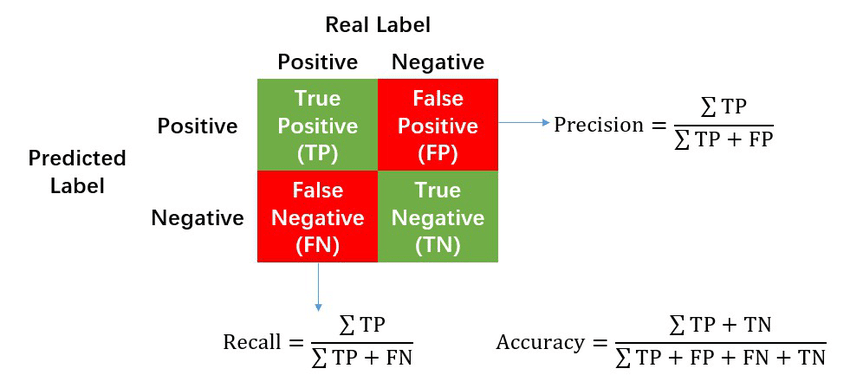

> Source: https://www.researchgate.net/figure/Calculation-of-Precision-Recall-and-Accuracy-in-the-confusion-matrix_fig3_336402347

In this task, I believe **precision** is the primary metrics that need to be accounted for. We want to predict which customers are retained to find out if certain campaigns have an impact. If we wrongly predict retained customers, then we might conclude that the campaign must've had an impact. The company could decide to extend the campaign or held it again in the future eventhough the cost of holding a campaign is not cheap.

On the other hand, if we precisely predict which customer is retained, we can draw better conclusions about the campaign. We could save our money to held campaigns that brings significant impact.

Based on the precision formula, we could deduct that "FP" or false positive is a factor that we prefer to minimize, rather than "FN" in recall. It is aligned with my previous explanation.

# Data Understanding

In [ ]:
# load dataset into pandas dataframe
df = pd.read_csv("/content/ecommerce_masked_v3_3.csv", sep=';')

In [ ]:
# show the high-level information of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222378 entries, 0 to 222377
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   is_buyer_14d               222378 non-null  int64  
 1   total_voucher_claim_14d    124471 non-null  float64
 2   total_order_14d            154801 non-null  float64
 3   gmv_14d                    154801 non-null  float64
 4   pdp_views_14d              214023 non-null  float64
 5   shop_views_14d             161521 non-null  float64
 6   total_login_days_l14d      222378 non-null  int64  
 7   total_login_sessions_l14d  221588 non-null  float64
 8   use_ezpay                  154801 non-null  float64
 9   use_paylater               154801 non-null  float64
 10  use_cash_on_delivery       154801 non-null  float64
 11  use_virtual_account        154801 non-null  float64
 12  use_card_on_delivery       154801 non-null  float64
 13  label                      22

In [ ]:
# show the sample of data in the dataframe
df.sample()

,is_buyer_14d,total_voucher_claim_14d,total_order_14d,gmv_14d,pdp_views_14d,shop_views_14d,total_login_days_l14d,total_login_sessions_l14d,use_ezpay,use_paylater,use_cash_on_delivery,use_virtual_account,use_card_on_delivery,label
185083,0,NaN,NaN,NaN,30.0,NaN,1,10.0,NaN,NaN,NaN,NaN,NaN,1


## Feature variable

In [ ]:
# display the descriptive statistics of all numerical data (1)
# since there are lots of columns, the display will be seperated
df.describe().iloc[:, :6]

,is_buyer_14d,total_voucher_claim_14d,total_order_14d,gmv_14d,pdp_views_14d,shop_views_14d
count,222378.000000,124471.000000,154801.000000,1.548010e+05,214023.000000,161521.000000
mean,0.702448,21.013409,33.785699,4.384431e+06,1267.756877,285.102123
std,0.457182,26.724835,50.921570,1.631104e+07,2130.347194,613.307685
min,0.000000,10.000000,10.000000,0.000000e+00,10.000000,10.000000
25%,0.000000,10.000000,10.000000,4.899800e+05,140.000000,30.000000
50%,1.000000,10.000000,20.000000,1.340000e+06,530.000000,90.000000
75%,1.000000,20.000000,40.000000,3.450000e+06,1500.000000,270.000000
max,1.000000,1020.000000,5680.000000,1.355221e+09,62700.000000,24830.000000


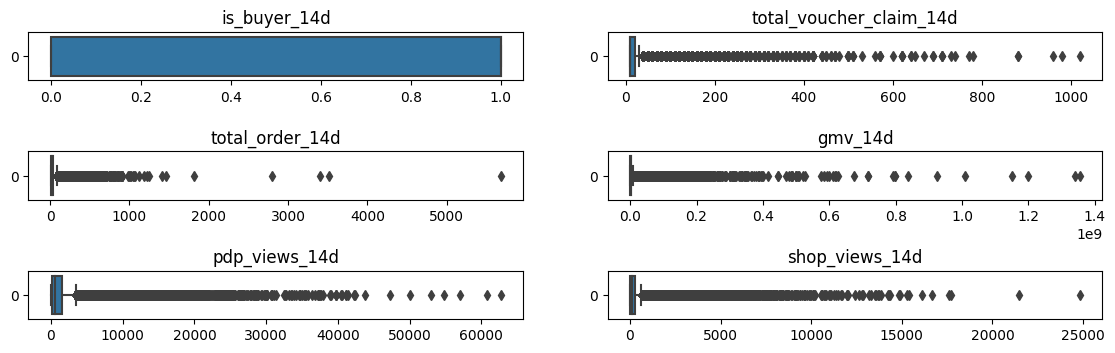

In [ ]:
# create multiple box-whisker plot to show data distribution
n_row = 3
n_col = 2
to_be_plotted = df.describe().iloc[:, :6].columns

fig, axs = plt.subplots(n_row, n_col, figsize=(12,4))
fig.tight_layout(pad=3)

counter = 0
for i in range(n_row):
  for j in range(n_col):
    sns.boxplot(data=df[to_be_plotted[counter]], orient='h', ax=axs[i, j])
    axs[i, j].set_title(to_be_plotted[counter])
    counter += 1

plt.show()

In [ ]:
# display the descriptive statistics of all numerical data (2)
# since there are lots of columns, the display will be seperated
df.describe().iloc[:, 6:12]

,total_login_days_l14d,total_login_sessions_l14d,use_ezpay,use_paylater,use_cash_on_delivery,use_virtual_account
count,222378.000000,221588.000000,154801.000000,154801.0,154801.000000,154801.000000
mean,6.982278,278.188124,3.233377,0.0,20.334042,2.047532
std,4.311525,337.743187,20.121578,0.0,34.864265,10.258989
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,3.000000,60.000000,0.000000,0.0,0.000000,0.000000
50%,7.000000,170.000000,0.000000,0.0,10.000000,0.000000
75%,11.000000,370.000000,0.000000,0.0,20.000000,0.000000
max,15.000000,8110.000000,5680.000000,0.0,1040.000000,2580.000000


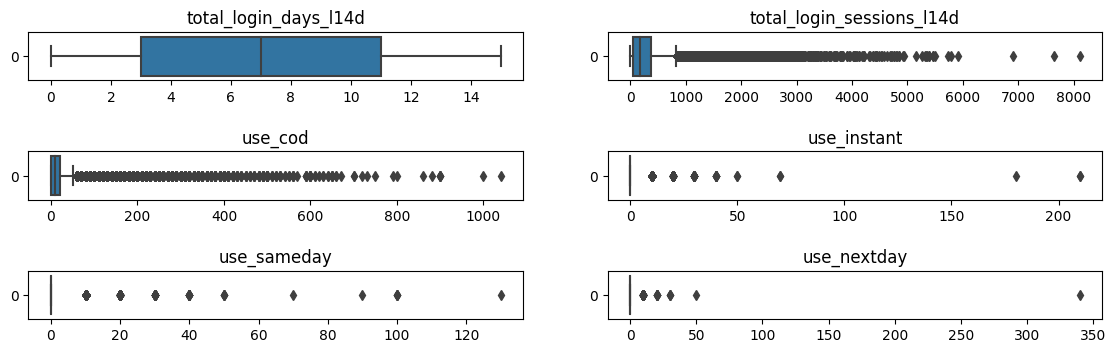

In [ ]:
# create multiple box-whisker plot to show data distribution
n_row = 3
n_col = 2
to_be_plotted = df.describe().iloc[:, 6:12].columns

fig, axs = plt.subplots(n_row, n_col, figsize=(12,4))
fig.tight_layout(pad=3)

counter = 0
for i in range(n_row):
  for j in range(n_col):
    sns.boxplot(data=df[to_be_plotted[counter]], orient='h', ax=axs[i, j])
    axs[i, j].set_title(to_be_plotted[counter])
    counter += 1

plt.show()

In [ ]:
# display the descriptive statistics of all numerical data (2)
# since there are lots of columns, the display will be seperated
df.describe().iloc[:, 12:13]

,use_card_on_delivery
count,154801.000000
mean,0.037080
std,1.046056
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,100.000000


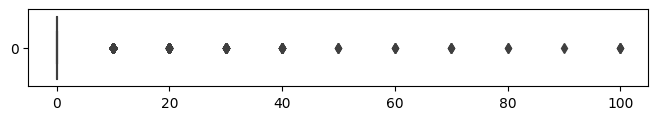

In [ ]:
plt.figure(figsize=(8,1))
sns.boxplot(data=df["use_card_on_delivery"], orient='h')
plt.show()

> I deliberately did not visualize `label` since it is the target variable (will be visualized in another subsection)

## Target variable

In [ ]:
# checks how imbalanced the target data is
fig = px.pie(df, names="label", width=300, height=300)
fig.update_layout(margin=dict(t=20, b=0))
fig.show()

> The target data is just slightly imbalanced. Therefore I would not take this into account in the modelling phase.

# Data Preparation

## Data cleansing

In [ ]:
df_clean = df.copy()

At a glance, we could see from `df.info()` result that the "non-null" values are varies between all the predictor columns. It indicates that this dataset contains missing values. Therefore, we need to handle this situation.

The most straightforward approach to handle missing value could be done by deleting all rows that contains it

In [ ]:
# check the amount of missing values (based on rows)
droprow_strategy = df_clean.dropna()
print("Number of row(s) WITH missing values: %d" % (df_clean.shape[0]))
print("Number of row(s) WITHOUT missing values: %d" % (droprow_strategy.shape[0]))
print("Percentage of missing values in the dataset: %.2f" % ((df_clean.shape[0] - droprow_strategy.shape[0])/df_clean.shape[0]*100))

Number of row(s) WITH missing values: 222378
Number of row(s) WITHOUT missing values: 95188
Percentage of missing values in the dataset: 57.20


> Based on the number above, we should not handle the missing value by simply dropping any rows that contains null. Why? Because almost all of the rows contains missing value. If we drop those rows, we could lost the importance of the data itself because we only has the small amount of the remaining rows.

I wil try is to observe the number of missing values per column instead of row.

In [ ]:
def null_check_per_column(dataframe):
  col_na = dataframe.isnull().sum().sort_values(ascending=False)
  percent = round(col_na/len(dataframe)*100, 2)
  data_type = dataframe.dtypes
  missing_data = pd.concat([col_na, percent, data_type], axis=1, keys=['Count of Missing Values', 'Percentage (%)', 'Data Type'])
  missing_data
  res = missing_data[missing_data['Count of Missing Values'] > 0]
  print(res)
  print('\n')
  print("The number of columns that contains missing values are: {}".format(len(res)))

In [ ]:
# check the amount of missing values (based on columns)
null_check_per_column(df_clean)

                           Count of Missing Values  Percentage (%) Data Type
total_voucher_claim_14d                      97907           44.03   float64
total_order_14d                              67577           30.39   float64
gmv_14d                                      67577           30.39   float64
use_ezpay                                    67577           30.39   float64
use_paylater                                 67577           30.39   float64
use_cash_on_delivery                         67577           30.39   float64
use_virtual_account                          67577           30.39   float64
use_card_on_delivery                         67577           30.39   float64
shop_views_14d                               60857           27.37   float64
pdp_views_14d                                 8355            3.76   float64
total_login_sessions_l14d                      790            0.36   float64


The number of columns that contains missing values are: 11


I would drop a column if half or more of its cells is detected as a missing value. I might be able to impute a value to those cells, but I believe it will be in vain as the imputed results no longer represent the actual conditions.

Since all the column's missing value percentage is < 50%, I will impute them with some value. I'll be using SKLearn's IterativeImputer that applies MICE technique.

In [40]:
imputer = IterativeImputer(verbose=2, random_state=42)

In [41]:
df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

[IterativeImputer] Completing matrix with shape (222378, 14)
[IterativeImputer] Ending imputation round 1/10, elapsed time 3.59
[IterativeImputer] Change: 27155509.389198903, scaled tolerance: 1355221.02 
[IterativeImputer] Ending imputation round 2/10, elapsed time 6.48
[IterativeImputer] Change: 34264922.73196134, scaled tolerance: 1355221.02 
[IterativeImputer] Ending imputation round 3/10, elapsed time 10.23
[IterativeImputer] Change: 24721675.70538261, scaled tolerance: 1355221.02 
[IterativeImputer] Ending imputation round 4/10, elapsed time 15.03
[IterativeImputer] Change: 20883272.110120717, scaled tolerance: 1355221.02 
[IterativeImputer] Ending imputation round 5/10, elapsed time 18.78
[IterativeImputer] Change: 13701844.602886712, scaled tolerance: 1355221.02 
[IterativeImputer] Ending imputation round 6/10, elapsed time 22.15
[IterativeImputer] Change: 7875722.106310061, scaled tolerance: 1355221.02 
[IterativeImputer] Ending imputation round 7/10, elapsed time 27.61
[Itera

In [42]:
# check the amount of missing values (based on columns)
null_check_per_column(df_clean)

Empty DataFrame
Columns: [Count of Missing Values, Percentage (%), Data Type]
Index: []


The number of columns that contains missing values are: 0


> There is no more missing values on `df_clean`

In [43]:
# check whether there are duplicated row in the dataframe
df_clean.duplicated().sum()

27178

In [46]:
# drop duplicated row
df_clean.drop_duplicates(inplace=True, ignore_index=True)

In [47]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195200 entries, 0 to 195199
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   is_buyer_14d               195200 non-null  float64
 1   total_voucher_claim_14d    195200 non-null  float64
 2   total_order_14d            195200 non-null  float64
 3   gmv_14d                    195200 non-null  float64
 4   pdp_views_14d              195200 non-null  float64
 5   shop_views_14d             195200 non-null  float64
 6   total_login_days_l14d      195200 non-null  float64
 7   total_login_sessions_l14d  195200 non-null  float64
 8   use_ezpay                  195200 non-null  float64
 9   use_paylater               195200 non-null  float64
 10  use_cash_on_delivery       195200 non-null  float64
 11  use_virtual_account        195200 non-null  float64
 12  use_card_on_delivery       195200 non-null  float64
 13  label                      19

In [48]:
df_clean.sample()

,is_buyer_14d,total_voucher_claim_14d,total_order_14d,gmv_14d,pdp_views_14d,shop_views_14d,total_login_days_l14d,total_login_sessions_l14d,use_ezpay,use_paylater,use_cash_on_delivery,use_virtual_account,use_card_on_delivery,label
4370,1.0,10.0,20.0,1862420.0,3630.0,520.0,12.0,740.0,0.0,0.0,20.0,0.0,0.0,0.0


> Up until here the dataset has been cleansed. The size of row has been reduced from 222.378 to 195.200

## Feature engineering

In [53]:
# deselect target feature
numerical_data = df_clean.select_dtypes('number').drop('label', axis='columns')

# standardize the data
df_scaled = pd.DataFrame()
df_scaled[numerical_data.columns] = RobustScaler().fit_transform(numerical_data)
df_scaled.head()

,is_buyer_14d,total_voucher_claim_14d,total_order_14d,gmv_14d,pdp_views_14d,shop_views_14d,total_login_days_l14d,total_login_sessions_l14d,use_ezpay,use_paylater,use_cash_on_delivery,use_virtual_account,use_card_on_delivery
0,-1.0,-0.745757,-0.263358,0.005068,-0.193103,-0.037669,-0.571429,-0.483871,-2.114083,0.0,0.008495,0.866819,0.019137
1,-1.0,-0.824165,-0.356577,-0.041115,-0.413793,-0.349787,-0.428571,-0.516129,-2.508634,0.0,-0.037451,0.861364,0.023171
2,-1.0,-0.747293,-0.233493,0.011125,0.089655,0.262874,-0.571429,-0.548387,-2.144552,0.0,0.010071,0.891918,0.019238
3,-1.0,-0.775311,-0.257702,0.037588,-0.393103,-0.214205,-0.857143,-0.612903,-2.127226,0.0,0.061275,0.783546,0.012013
4,-1.0,-0.495339,-0.185288,-0.057828,0.089655,0.050000,0.142857,0.258065,-1.253236,0.0,-0.081850,1.060063,0.034695


## Training & validation set

In [54]:
# select independent variable that will be used as predictor feature (X)
feature = df_scaled

In [55]:
# select dependent variable that will be used as target (y)
target = df_clean['label']

In [58]:
# seggregate training & testing set
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state=42)

# Modeling

## KKN

The excess amount of predictor attributes might lead to "curse of dimentionality" phenomenon. Hence, I conduct feature selection with SelectKBest that utilize a univariate statistical test. I will select 5 best feature.

In [62]:
selector = SelectKBest(k=5, score_func=f_classif)
selector.fit_transform(X_train, y_train)
selected_feature = selector.get_feature_names_out()
selected_feature

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [9] are constant.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide



array(['total_voucher_claim_14d', 'total_order_14d',
       'total_login_days_l14d', 'total_login_sessions_l14d',
       'use_cash_on_delivery'], dtype=object)

In [63]:
X_train_knn = X_train[selected_feature]
X_test_knn = X_test[selected_feature]

### initial training

In [64]:
# model training
knn = KNeighborsClassifier()
knn.fit(X_train_knn, y_train)

KNeighborsClassifier()

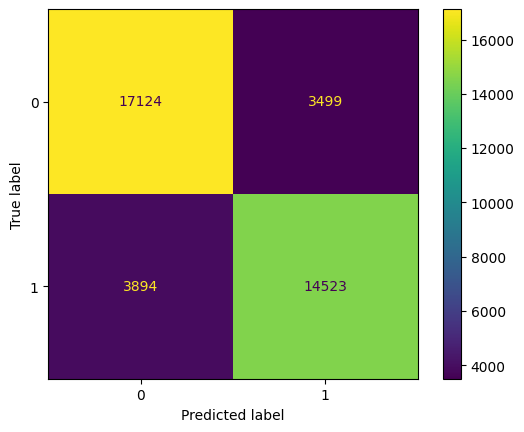

In [65]:
# model evaluation: confusion matrix
knn_predictions = knn.predict(X_test_knn)
cm = confusion_matrix(y_test, knn_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [66]:
# model evaluation: classification metrics
temp = precision_score(y_test, knn_predictions)
print("Model precision: %.3f" % (temp))

temp = recall_score(y_test, knn_predictions)
print("Model recall: %.3f" % (temp))

Model precision: 0.806
Model recall: 0.789


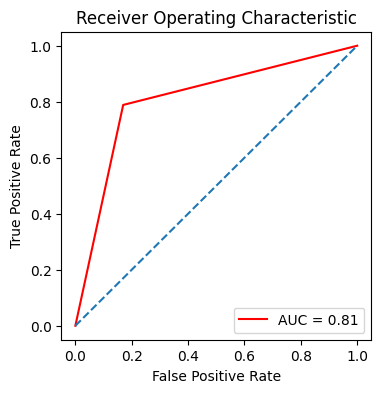

In [67]:
# model evaluation: ROC-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, knn_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(4,4))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### hyperparameter tuning

I chose to tune-in the `n_neighbors` hyperparam. As KNN is abbreviation of K-nearest neighbors, this hyperparam tells the model how many data points sorrounding a particular data that need to be considered in the "voting" phase of KNN. I conduct this tuning by running the GridSearchCV that will cross-validate the result by repeating the process K time.

In [68]:
# grid search cross validation
param_grid = {'n_neighbors' : [3, 5, 15, 75, 1125]}
gs = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=3, cv=3, refit='precision')
gs.fit(X_train_knn, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .....................n_neighbors=3;, score=0.802 total time=   2.0s
[CV 2/3] END .....................n_neighbors=3;, score=0.803 total time=   2.3s
[CV 3/3] END .....................n_neighbors=3;, score=0.802 total time=   2.1s
[CV 1/3] END .....................n_neighbors=5;, score=0.807 total time=   3.2s
[CV 2/3] END .....................n_neighbors=5;, score=0.808 total time=   2.3s
[CV 3/3] END .....................n_neighbors=5;, score=0.809 total time=   2.4s
[CV 1/3] END ....................n_neighbors=15;, score=0.817 total time=   2.5s
[CV 2/3] END ....................n_neighbors=15;, score=0.818 total time=   2.6s
[CV 3/3] END ....................n_neighbors=15;, score=0.818 total time=   3.6s
[CV 1/3] END ....................n_neighbors=75;, score=0.815 total time=   4.2s
[CV 2/3] END ....................n_neighbors=75;, score=0.818 total time=   4.2s
[CV 3/3] END ....................n_neighbors=75;,

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 15, 75, 1125]},
             refit='precision', verbose=3)

In [69]:
# model training
knn2 = KNeighborsClassifier(**gs.best_params_)
knn2.fit(X_train_knn, y_train)

KNeighborsClassifier(n_neighbors=15)

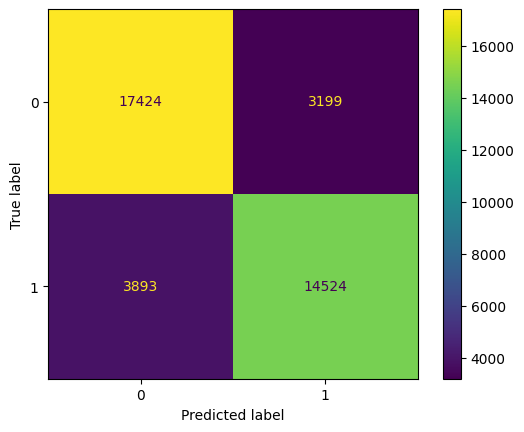

In [70]:
# model evaluation: confusion matrix
knn2_predictions = knn2.predict(X_test_knn)
cm = confusion_matrix(y_test, knn2_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [71]:
# model evaluation: classification metrics
temp = precision_score(y_test, knn2_predictions)
print("Model precision: %.3f" % (temp))

temp = recall_score(y_test, knn2_predictions)
print("Model recall: %.3f" % (temp))

Model precision: 0.820
Model recall: 0.789


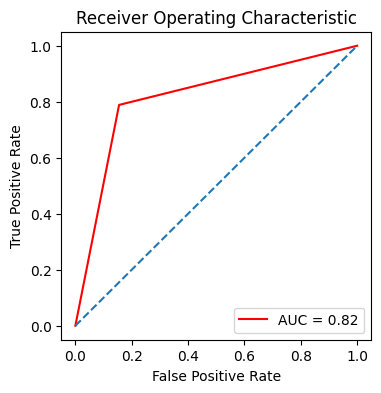

In [72]:
# model evaluation: ROC-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, knn2_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(4,4))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

> The result is indeed better. In the default model `n_neighbors = 5`, meanwhile this tuned-in model `n_neighbors = 15`.

## Random forest

### initial training

In [73]:
# construct the model
# default number of estimator is 100
rf = RandomForestClassifier(random_state=42)

In [74]:
# model training
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

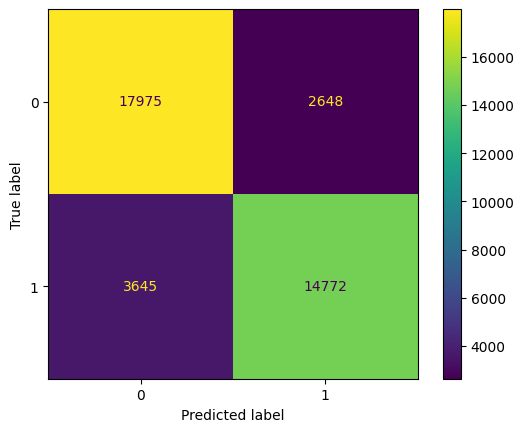

In [75]:
# model evaluation: confusion matrix
rf_predictions = rf.predict(X_test)
cm = confusion_matrix(y_test, rf_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [76]:
# model evaluation: classification metrics
temp = precision_score(y_test, rf_predictions)
print("Model precision: %.3f" % (temp))

temp = recall_score(y_test, rf_predictions)
print("Model recall: %.3f" % (temp))

Model precision: 0.848
Model recall: 0.802


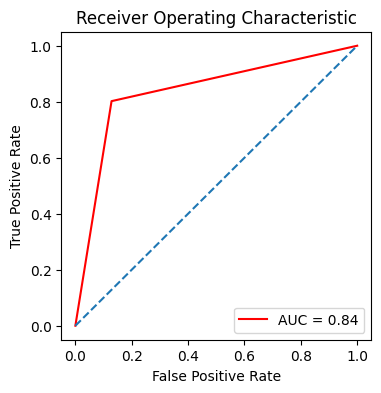

In [77]:
# model evaluation: ROC-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(4,4))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### hyperparameter tuning

I chose to tune-in the `n_estimators` and `min_samples_leaf` hyperparam. Random forest is basically a group of decision tree, `n_estimator` tells the model how many individual decision tree (estimator) it needs to use. On the other hand, `min_samples_leaf` tells the model about how many data point (samples) needs to be in a leaf/node before splitting decision could be made. If the number of data point is below the threshold, then the model won't split it further.

In [78]:
param_grid = {'n_estimators': [100, 200, 400],
              'min_samples_leaf': [1, 50, 100]}
gs = GridSearchCV(RandomForestClassifier(), param_grid, verbose = 3, cv=3, refit='precision')
gs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END min_samples_leaf=1, n_estimators=100;, score=0.836 total time=  27.2s
[CV 2/3] END min_samples_leaf=1, n_estimators=100;, score=0.839 total time=  19.2s
[CV 3/3] END min_samples_leaf=1, n_estimators=100;, score=0.839 total time=  31.1s
[CV 1/3] END min_samples_leaf=1, n_estimators=200;, score=0.837 total time=  43.1s
[CV 2/3] END min_samples_leaf=1, n_estimators=200;, score=0.840 total time=  42.5s
[CV 3/3] END min_samples_leaf=1, n_estimators=200;, score=0.840 total time=  39.4s
[CV 1/3] END min_samples_leaf=1, n_estimators=400;, score=0.838 total time= 1.3min
[CV 2/3] END min_samples_leaf=1, n_estimators=400;, score=0.840 total time= 1.3min
[CV 3/3] END min_samples_leaf=1, n_estimators=400;, score=0.840 total time= 1.3min
[CV 1/3] END min_samples_leaf=50, n_estimators=100;, score=0.833 total time=  13.2s
[CV 2/3] END min_samples_leaf=50, n_estimators=100;, score=0.835 total time=  13.3s
[CV 3/3] END min_samples_

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 50, 100],
                         'n_estimators': [100, 200, 400]},
             refit='precision', verbose=3)

In [79]:
# showing best hyperparameter based on previous configuration
gs.best_params_

{'min_samples_leaf': 1, 'n_estimators': 400}

In [80]:
# model training
rf2 = RandomForestClassifier(**gs.best_params_)
rf2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400)

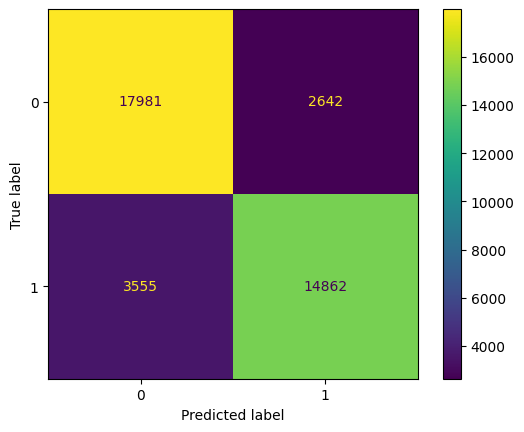

In [81]:
# model evaluation: confusion matrix
rf2_predictions = rf2.predict(X_test)
cm = confusion_matrix(y_test, rf2_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [82]:
# model evaluation: classification metrics
temp = precision_score(y_test, rf2_predictions)
print("Model precision: %.3f" % (temp))

temp = recall_score(y_test, rf2_predictions)
print("Model recall: %.3f" % (temp))

Model precision: 0.849
Model recall: 0.807


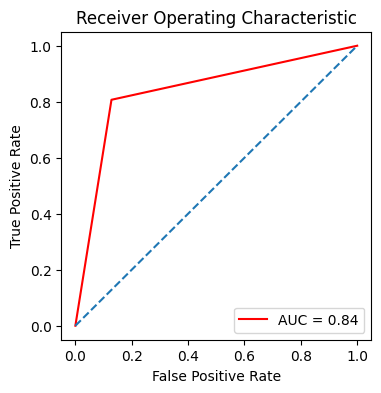

In [83]:
# model evaluation: ROC-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf2_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(4,4))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

> The result is slightly better. In the default model `n_estimators = 100`, meanwhile this tuned-in model `n_estimators = 400`. Note the k-CV used in this experiment is only 3. For further tuning, it also good to adding more k-CV so that the result becoming more reliable. Moreover, it is also a good idea to try out another hyperparameter combinations.

## Multi layer perceptron

### initial training

In [84]:
# model training
neural_net = MLPClassifier(random_state=42, verbose=True)
neural_net.fit(X_train, y_train)

Iteration 1, loss = 0.46692116
Iteration 2, loss = 0.41389844
Iteration 3, loss = 0.40036672
Iteration 4, loss = 0.39398832
Iteration 5, loss = 0.38829785
Iteration 6, loss = 0.38337014
Iteration 7, loss = 0.37710067
Iteration 8, loss = 0.37179311
Iteration 9, loss = 0.36656209
Iteration 10, loss = 0.36131965
Iteration 11, loss = 0.35739431
Iteration 12, loss = 0.35403439
Iteration 13, loss = 0.35078777
Iteration 14, loss = 0.34820477
Iteration 15, loss = 0.34590344
Iteration 16, loss = 0.34397383
Iteration 17, loss = 0.34209538
Iteration 18, loss = 0.34077809
Iteration 19, loss = 0.33888713
Iteration 20, loss = 0.33817353
Iteration 21, loss = 0.33668249
Iteration 22, loss = 0.33561951
Iteration 23, loss = 0.33473883
Iteration 24, loss = 0.33449717
Iteration 25, loss = 0.33343943
Iteration 26, loss = 0.33251871
Iteration 27, loss = 0.33194463
Iteration 28, loss = 0.33052132
Iteration 29, loss = 0.33062232
Iteration 30, loss = 0.32992250
Iteration 31, loss = 0.32970676
Iteration 32, los

MLPClassifier(random_state=42, verbose=True)

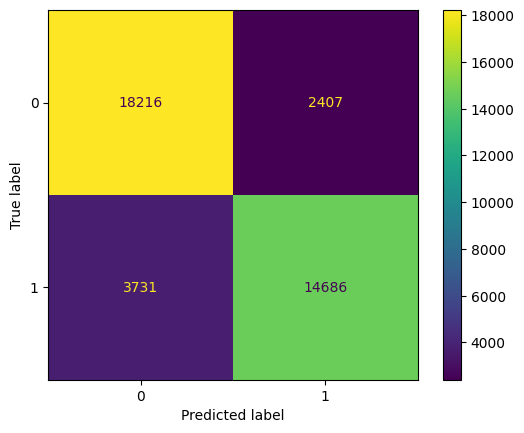

In [85]:
# model evaluation: confusion matrix
neural_net_predictions = neural_net.predict(X_test)
cm = confusion_matrix(y_test, neural_net_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [86]:
# model evaluation: classification metrics
temp = precision_score(y_test, neural_net_predictions)
print("Model precision: %.3f" % (temp))

temp = recall_score(y_test, neural_net_predictions)
print("Model recall: %.3f" % (temp))

Model precision: 0.859
Model recall: 0.797


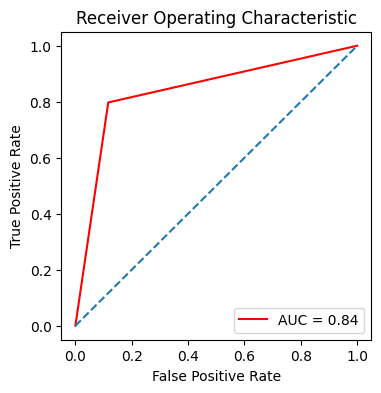

In [87]:
# model evaluation: ROC-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, neural_net_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(4,4))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### hyperparameter tuning

I chose to tune-in the `alpha` and `hidden_layer_sizes` hyperparam. `alpha` is a penalty term. Theoretically, increasing this hyperparam will fix high variance (a sign of overfitting) by encouraging smaller weights. On the contrary, decreasing this hyperparam may fix high bias (a sign of underfitting) by encouraging larger weights. `hidden_layer_sizes` control the architecture of the MLP (neural network) itself. Finally, I set an arbitrary `max_iter` hyperparam to be 500 instead of 100 (default). This hyperparam controls how many cycle in which the model needs to learn.

In [88]:
param_grid = {'alpha': [0.01, 0.001, 0.0001],
              'hidden_layer_sizes': [(100,), (64,32,16)]}
gs = GridSearchCV(MLPClassifier(max_iter=500), param_grid, verbose=3, cv=3, refit='precision')
gs.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END alpha=0.01, hidden_layer_sizes=(100,);, score=0.840 total time= 1.9min
[CV 2/3] END alpha=0.01, hidden_layer_sizes=(100,);, score=0.839 total time= 2.1min
[CV 3/3] END alpha=0.01, hidden_layer_sizes=(100,);, score=0.841 total time= 2.2min
[CV 1/3] END alpha=0.01, hidden_layer_sizes=(64, 32, 16);, score=0.845 total time= 1.4min
[CV 2/3] END alpha=0.01, hidden_layer_sizes=(64, 32, 16);, score=0.844 total time= 2.2min
[CV 3/3] END alpha=0.01, hidden_layer_sizes=(64, 32, 16);, score=0.845 total time= 2.7min
[CV 1/3] END alpha=0.001, hidden_layer_sizes=(100,);, score=0.838 total time= 1.4min
[CV 2/3] END alpha=0.001, hidden_layer_sizes=(100,);, score=0.839 total time= 2.1min
[CV 3/3] END alpha=0.001, hidden_layer_sizes=(100,);, score=0.838 total time= 2.2min
[CV 1/3] END alpha=0.001, hidden_layer_sizes=(64, 32, 16);, score=0.842 total time= 3.0min
[CV 2/3] END alpha=0.001, hidden_layer_sizes=(64, 32, 16);, score=0.842 

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=500),
             param_grid={'alpha': [0.01, 0.001, 0.0001],
                         'hidden_layer_sizes': [(100,), (64, 32, 16)]},
             refit='precision', verbose=3)

In [89]:
# showing best hyperparameter based on previous configuration
gs.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': (64, 32, 16)}

In [90]:
# model training
neural_net_2 = MLPClassifier(**gs.best_params_, verbose=True)
neural_net_2.fit(X_train, y_train)

Iteration 1, loss = 0.43823973
Iteration 2, loss = 0.38387149
Iteration 3, loss = 0.35750625
Iteration 4, loss = 0.34223389
Iteration 5, loss = 0.33351606
Iteration 6, loss = 0.32880438
Iteration 7, loss = 0.32493349
Iteration 8, loss = 0.32220446
Iteration 9, loss = 0.32018028
Iteration 10, loss = 0.31745646
Iteration 11, loss = 0.31701594
Iteration 12, loss = 0.31536984
Iteration 13, loss = 0.31516560
Iteration 14, loss = 0.31353982
Iteration 15, loss = 0.31333391
Iteration 16, loss = 0.31183066
Iteration 17, loss = 0.31208157
Iteration 18, loss = 0.31123402
Iteration 19, loss = 0.31116272
Iteration 20, loss = 0.30999124
Iteration 21, loss = 0.30932725
Iteration 22, loss = 0.30925663
Iteration 23, loss = 0.30901541
Iteration 24, loss = 0.30851137
Iteration 25, loss = 0.30831543
Iteration 26, loss = 0.30826099
Iteration 27, loss = 0.30821771
Iteration 28, loss = 0.30725159
Iteration 29, loss = 0.30739027
Iteration 30, loss = 0.30693179
Iteration 31, loss = 0.30727947
Iteration 32, los

MLPClassifier(alpha=0.01, hidden_layer_sizes=(64, 32, 16), verbose=True)

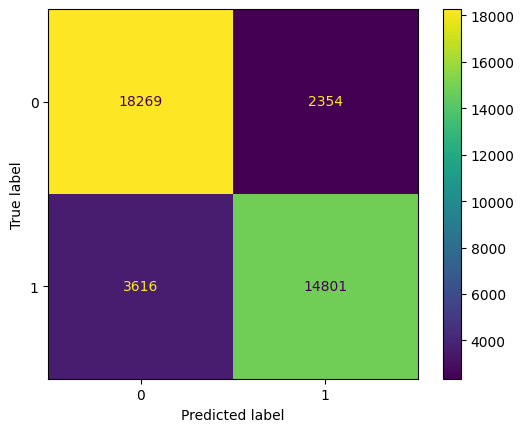

In [91]:
# model evaluation: confusion matrix
neural_net_2_predictions = neural_net_2.predict(X_test)
cm = confusion_matrix(y_test, neural_net_2_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [92]:
# model evaluation: classification metrics
temp = precision_score(y_test, neural_net_2_predictions)
print("Model precision: %.3f" % (temp))

temp = recall_score(y_test, neural_net_2_predictions)
print("Model recall: %.3f" % (temp))

Model precision: 0.863
Model recall: 0.804


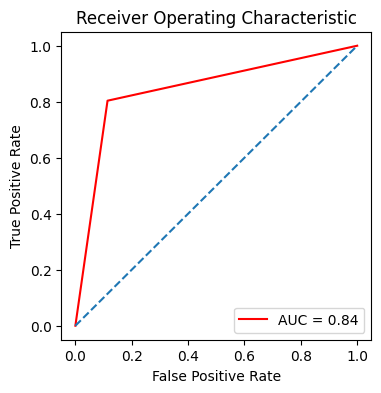

In [93]:
# model evaluation: ROC-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, neural_net_2_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(4,4))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

> The result is a little bit better.

> Tuning a neural network itself is time-consuming if compared to the more traditional model. Hence I'm not experimenting with lots of hyperparam because of resource limitation reason.

# Evaluation & Conclusion

Based on the evaluation of 3 models that I've made, the best model is MLP classifier (neural network) with ~0.86 precision score and ~0.84 AUC

Based on the feature selection process (with SelectKBest), some attributes that considered to influence customer retention are: `total_voucher_claim_14d`, `total_order_14d`, `total_login_days_l14d`, `total_login_sessions_l14d`, and `use_cash_on_delivery`.